In [1]:
import Plots, DataFrames, CSV
import Statistics
print("Done")

Done

# 1 (a)

In [77]:
N = 15000

μ = [-2.5, 1.4]
C = zeros(2,2)
C[1, :] = [2, 1]
C[2, :] = [1, 2]

samples = zeros(N, 2)
@show size(samples), size(C)

for i in 1:N
   samples[i, :] = μ + (randn(2)' * C)'
end

@show size(samples)

p_sam = Plots.scatter(
    samples[:,1],samples[:,2],
    size=(400,250),
    markerstrokewidth=0,markersize=1,
    legend=false)

(size(samples), size(C)) = ((15000, 2), (2, 2))
size(samples) = (15000, 2)


In [63]:
μ + (randn(2)' * C)'

2-element Vector{Float64}:
 -1.6352333939546173
  5.095405952822787

# 1 b)

In [118]:
function cond_fst(X, x0; d=0.1)
    return X[x0-d .< X[:, 1] .< x0+d, :]
end

function cond_snd(X, y0; d=0.1)
    return X[y0-d .< X[:, 2] .< y0+d, :]
end

cond_snd (generic function with 1 method)

# 1 c) 

Each function basically restricts the set of samples to a certain range, hence the lines

In [121]:
for i in [-1, 0, 1,2]
    filtered = cond_fst(samples, i)
    p_sam = Plots.scatter(p_sam,
        filtered[:,1],filtered[:,2],
        size=(400,250),
        markerstrokewidth=0,markersize=1,
        legend=false,
        color="red"
    )
end

filtered = cond_snd(samples, 1.4)
p_sam = Plots.scatter(p_sam,
    filtered[:,1],filtered[:,2],
    size=(400,250),
    markerstrokewidth=0,markersize=1,
    legend=false,
    color="cyan"
)

p_sam

# 2 a)


In [3]:
data = CSV.read(
    "data/emnist_train.csv",
    DataFrames.DataFrame,
    header=false
)

@show size(data)

size(data) = (240000, 785)


(240000, 785)

In [33]:
using Colors, Plots

function get_image(idx)
    sample = data[idx, :]
    label = sample[1]
    img_vectorized = sample[2:end]
    img = reshape([x for x in img_vectorized], 28,28)
    return img, label
end

get_image (generic function with 1 method)

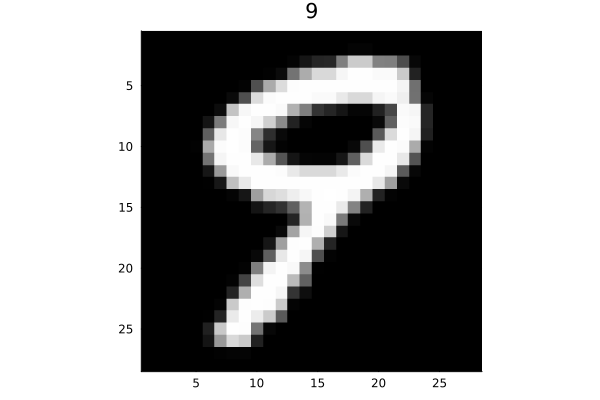

In [43]:
img, label = get_image(2)
plot(Gray.(img/255), title=string(label))


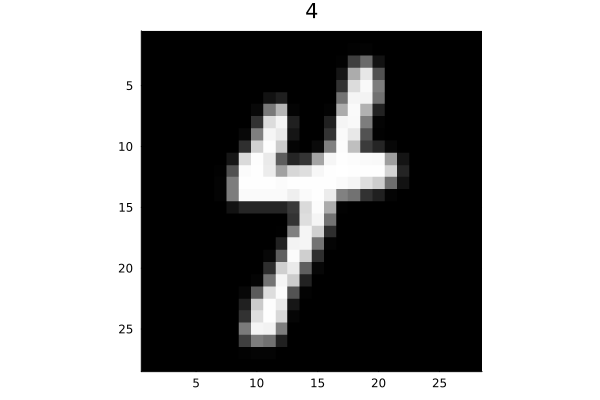

In [44]:
img, label = get_image(34)
plot(Gray.(img/255), title=string(label))

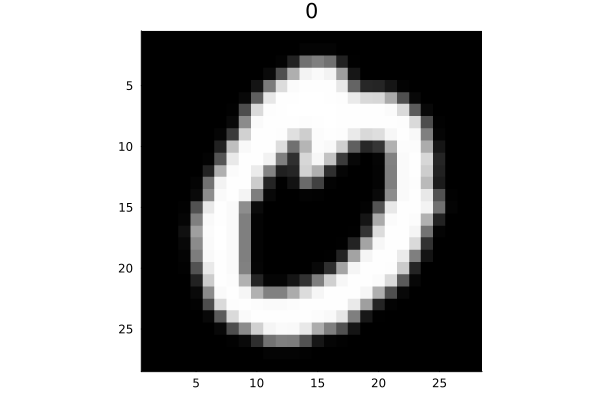

In [45]:
img, label = get_image(5324)
plot(Gray.(img/255), title=string(label))

# 2 b)

1. Regression is suitable for continous functions, while MNIST has discrete labels. Hence mapping continous values to discrete ones is be suboptimal and difficult to learn
2. The loss function for regression usually measures the distance between the target and the prediction, and in this case is not really suitable

# 2 c)

The number of possible orderings is combinations of 10 taken by 10 which is 10! / (10! * (10-10)!) = 1 because we want to combine 10 classes in a subset of 10.

# 2 d)

In [159]:
function get_classification_data(all_data, S1, S2, N)
    S1s = []
    S2s = []
    i = 1
    while i <= size(all_data)[1]
        sample = [x for x in all_data[i, :]]
        
        if sample[1] == S1 && length(S1s) < N/2
            append!(S1s, [sample])
        end
        
        if sample[1] == S2 && length(S2s) < N/2
            append!(S2s, [sample])
        end
        i += 1
    end
    
    X = zeros(N, 784)
    Y = zeros(N, 1)
    for i in range(1,length(S1s), step=1)
       sample = S1s[i]
        X[i, :] .= sample[2:end]
        Y[i, :] .= 1
    end
    
    for i in range(1,length(S2s), step=1)
        sample = S2s[i]
        X[i+length(S1s), :] .= sample[2:end]
        Y[i+length(S1s), :] .= 0 #used 0 instead of -1
    end
    
    return X, Y
end

get_classification_data (generic function with 1 method)

In [160]:
get_classification_data(data[1:1000, :], 6, 9, 10)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1.0; 1.0; … ; 0.0; 0.0;;])

# 2 e)

In [205]:
import Statistics

# mean squared error
error(Y, y_pred) = Statistics.mean((Y - y_pred) .^ 2)
error_der(Y, y_pred, X) =  -2 * Statistics.mean(X .* (Y - y_pred), dims=1)




# gradient descent
function train(X, Y, epochs=100, learning_rate=0.1)
    θ = rand(size(X)[2], 1)
    #@show θ
    for epoch in 1 : epochs
        # compute the forward pass
        #@show size(X), size(θ)
        y_pred = X./255 * θ
        y_pred = 1.0 ./ ( 1.0 .+ exp.(-y_pred./100) ) 
        
        
        #@show size(y_pred)
        #break
        # compute the error
        loss = error(Y, y_pred)
        @show epoch, loss 
        θ_derivate = error_der(Y, y_pred, X) * loss * (1-loss) #-2 * Statistics.mean(X .* (Y - y_pred) .* loss .* (1.0 .-loss), dims=1)
        
        # update weights
        θ = θ .- learning_rate * θ_derivate'
    end
    return θ 
end

train (generic function with 3 methods)

In [197]:
X, Y = get_classification_data(data[1:100000, :], 6, 9, 5000)
@show size(X), size(Y)

(size(X), size(Y)) = ((5000, 784), (5000, 1))


((5000, 784), (5000, 1))

In [211]:
θ = train(X, Y, 40, 3e-2)

(epoch, loss) = (1, 0.26834245772429266)
(epoch, loss) = (2, 0.21770864658640784)
(epoch, loss) = (3, 0.18479854198596382)
(epoch, loss) = (4, 0.16201151942725933)
(epoch, loss) = (5, 0.1451765112453165)
(epoch, loss) = (6, 0.13213434425629111)
(epoch, loss) = (7, 0.12167855325729647)
(epoch, loss) = (8, 0.11307841785592036)
(epoch, loss) = (9, 0.10586166136246479)
(epoch, loss) = (10, 0.09970732947780421)
(epoch, loss) = (11, 0.0943885911994757)
(epoch, loss) = (12, 0.08974004167180351)
(epoch, loss) = (13, 0.08563793979681486)
(epoch, loss) = (14, 0.08198770933998459)
(epoch, loss) = (15, 0.0787157336127837)
(epoch, loss) = (16, 0.07576379868228182)
(epoch, loss) = (17, 0.07308522974755237)
(epoch, loss) = (18, 0.07064214321930339)
(epoch, loss) = (19, 0.06840345336493377)
(epoch, loss) = (20, 0.06634340095440115)
(epoch, loss) = (21, 0.06444045027746811)
(epoch, loss) = (22, 0.06267645075087462)
(epoch, loss) = (23, 0.06103599160341945)
(epoch, loss) = (24, 0.05950589948077112)
(epo

784×1 Matrix{Float64}:
 0.2996437274582333
 0.7713335574973162
 0.48369484124587403
 0.5568671593938449
 0.31310197311124366
 0.48849748850275865
 0.11399334214487378
 0.9734541382883253
 0.053597924583985046
 0.5586339065344569
 0.5442577182251999
 0.015836372594676962
 0.31373745125100627
 ⋮
 0.9087661013219807
 0.6099354468980257
 0.032447271683240686
 0.33441939734705906
 0.09754535151353716
 0.9334106369134385
 0.6826645275283552
 0.8672375759506312
 0.22869269970036088
 0.4931052099871407
 0.9813305972365123
 0.9138036755015719

In [219]:
function sigmoid(z)
    return 1.0 ./ (1.0 .+ exp.(-z))
end


function predict(weights, sample)
   logit =  sample * weights
    logit =  logit[1]
    #@show logit
   return sigmoid(logit)
end

predict (generic function with 1 method)

In [212]:
idx = 4000
img = [x for x in X[idx, :]]
label = Y[idx]

@show label, size(img)

out = predict(θ, img')
@show out

(label, size(img)) = (0.0, (784,))
logit = -46286.01793809822
out = 0.0


0.0

In [225]:
idx = 1
img = [x for x in X[idx, :]]
label = Y[idx]

@show label, size(img)

out = predict(θ, img')
@show out

(label, size(img)) = (1.0, (784,))
out = 1.0


1.0

In [224]:
# training error
correct = 0
@show size(X)
for idx in range(1, size(X)[1], step=1)
    img = [x for x in X[idx, :]]
    label = Y[idx]

    out = predict(θ, img')
    if out == label
           correct += 1 
        end
end
    
accuracy = correct / size(X)[1]
@show accuracy
err = 1.0 - accuracy
@show err

size(X) = (5000, 784)
accuracy = 0.9948
err = 0.005199999999999982


0.005199999999999982